# Plot Map

## Cluster Setting
Dask is a flexible library for parallel computing in Python. 

Dask.distributed is a lightweight library for distributed computing in Python.

The Client is the primary entry point for users of dask.distributed.

In [31]:
## Distributed computing
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster

cluster = KubeCluster() # reads provided yaml file
# cluster.scale_up(10)  # specify number of nodes explicitly
# cluster.adapt(minimum=1, maximum=100)  # or dynamically scale based on current workload
cluster.adapt(minimum = 2, maximum = 8)
cluster

distributed.scheduler - INFO - Clear task state
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.16.24:46553
distributed.scheduler - INFO -   dashboard at:                    :41713


In [32]:
# Connect to distributed cluster and override default
client = Client(cluster) 
client

distributed.scheduler - INFO - Receive client connection: Client-68cb7850-7862-11ea-8156-da33ed959bbe
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.16.24:46553 Dashboard: /user/0000-0002-3254-1210/proxy/41713/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


distributed.scheduler - INFO - Register tcp://10.32.18.13:41775
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.18.13:41775
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.18.14:38115
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.18.14:38115
distributed.core - INFO - Starting established connection


## Environment Setting

The pangeo platform is using an old version xesmf. In order to avoid error, we need to update the xesmf by execute the following code:

(it seems we need to do it every time)

In [33]:
!pip install --upgrade git+https://github.com/JiaweiZhuang/xESMF.git

  Cloning https://github.com/JiaweiZhuang/xESMF.git to /tmp/pip-req-build-nk589voq
  Running command git clone -q https://github.com/JiaweiZhuang/xESMF.git /tmp/pip-req-build-nk589voq
  Created wheel for xesmf: filename=xesmf-0.3.0-py3-none-any.whl size=20079 sha256=e64aae4457648be9c5223892f3f48065120a1f8b4a5f37bccbce8365bb00e7bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-ijj0kybl/wheels/d7/d9/36/77fa4453320fcc02ae0c467f668d1583e9fcbea536c2aaf287
Successfully built xesmf
  Attempting uninstall: xesmf
    Found existing installation: xesmf 0.3.0
    Uninstalling xesmf-0.3.0:
      Successfully uninstalled xesmf-0.3.0


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # Pythonic file-system for Google Cloud Storage
import xesmf as xe

%matplotlib inline

In [35]:
def get_data(df, var, model, expe, freq):
    try:
        uri = df[(df.variable_id == var) & \
                 (df.source_id == model) & \
                 (df.experiment_id == expe) & \
                 (df.table_id == freq)].zstore.values[0]
        gcs = gcsfs.GCSFileSystem(token='anon')
        ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    except:
        ds = []
        print(model, ": no data")
    return ds        

Fetch the data from 15 models that have biogeochem output.



In [66]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
models = ['CanESM5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GFDL-CM4',
          'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC', 'IPSL-CM6A-LR', 'MIROC-ES2L',
          'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM', 'UKESM1-0-LL']

var = 'intpp'
expe = 'historical'
freq = 'Omon'

start_time = '1995'
end_time = '2014'
#seconf set for the end of 100 years
expe2 = 'ssp585'
start_time2 = '2081'
end_time2 = '2100' #2099


xrays = []
xrays2 = []
new_models = []

for model in models:
    print(model)
    xray = get_data(df, var, model, expe, freq)
    
    # if xray is not empty
    if isinstance(xray, xr.Dataset):  
         
        xray2 = get_data(df, var, model, expe2, freq)
        if isinstance(xray2, xr.Dataset):
            xrays.append(xray)
        
            xrays2.append(xray2)
        
            new_models.append(model)
        
xray_dic = {key:value for key, value in zip(new_models, xrays)}
xray2_dic = {key:value for key, value in zip(new_models, xrays2)}



CanESM5
CESM2
CESM2-WACCM
CNRM-ESM2-1
GFDL-CM4
GFDL-CM4 : no data
GFDL-ESM4
GFDL-ESM4 : no data
GISS-E2-1-G
GISS-E2-1-G : no data
GISS-E2-1-G-CC
GISS-E2-1-G-CC : no data
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-HR
MRI-ESM2-0
MRI-ESM2-0 : no data
NorCPM1
NorCPM1 : no data
NorESM2-LM
NorESM2-LM : no data
UKESM1-0-LL


In [67]:
print(new_models)

['CanESM5', 'CESM2', 'CESM2-WACCM', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']


### save file
no need to save file here, just for test.

In [ ]:
# no need to run this box

aves = []

for model in tqdm(models):
    try:
        ds = xray_dic[model].sel(time=slice('1990','2009')).mean(dim='time').tos
        
        if 'latitude' in ds.coords:
            ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
        if 'nav_lat' in ds.coords:
            ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
            
        ds = ds.load()
        outname = 'mean/' + str(model) + '.nc'
        ds.to_netcdf(outname)
            
    except Exception as E:
        ds = []
        print(model, E)

    aves.append(ds)

ave_dic = {key:value for key, value in zip(models, aves)}

## Regridding

Behzad's code for regridding:

nearest from scipy.interpolate.datagrid
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

Here we use xesmf
https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html


In [7]:
# Create a Global 2D rectilinear grid of 1 degree x 1 degree
ds_out = xe.util.grid_global(1, 1)
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [47]:
# Another method for out grid:
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 1.0)),
                     'lon': (['lon'], np.arange(0, 361, 1.0)),
                    }
                   )
ds_out

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 361)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
Data variables:
    *empty*

In [ ]:
#use the file that have been saved from above save file process
# no need to run this box

regrids = []
for model in tqdm(models):
    try:
        dsf = 'mean/' + str(model) + '.nc'
        ds = xr.open_dataset(dsf)
        
        dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        dsr_out = dsr(ds)
        dsr.clean_weight_file()
        
        #outname = 'Regrid/' + str(model) + '_reg.nc'
        #dsr_out.to_netcdf(outname)
        
    except Exception as E:
        dsr_out = []
        print(model, E)
    regrids.append(dsr_out)
regrid_dic = {key:value for key, value in zip(models, regrids)}

    regredding

In [64]:
#model = CanESM5
#xray_dic['GISS-E2-1-G'].sel(time=slice(start_time, end_time))[var]
    
            


<xarray.DataArray 'intpp' (time: 240, lat: 180, lon: 288)>
dask.array<getitem, shape=(240, 180, 288), dtype=float32, chunksize=(188, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 90.0
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 1995-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea depth: sum where sea time: mean
    comment:        Vertically integrated total primary (organic carbon) prod...
    long_name:      Primary Organic Carbon Production by All Types of Phytopl...
    standard_name:  net_primary_mole_productivity_of_biomass_expressed_as_car...
    units:          mol m-2 s-1

In [65]:
xray2_dic['GISS-E2-1-G'].sel(time=slice(start_time2, end_time2))[var]


AttributeError: 'list' object has no attribute 'sel'

In [68]:
%%time

regrids1 = []
regrids2 = []
regrids3 = []


for model in new_models:
#model = CanESM5
    #if isinstance(xray_dic[model], xr.Dataset):
       # if 'latitude' in ds.coords:
    if 'latitude' in xray_dic[model].coords:    
            xray_dic[model] = xray_dic[model].rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in xray_dic[model].coords:
            xray_dic[model] = xray_dic[model].rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    ds = xray_dic[model].sel(time=slice(start_time, end_time))[var]
    ds_end = xray2_dic[model].sel(time=slice(start_time2, end_time2))[var]
    ds_diff = ds_end-ds
        
            
                
    dsr = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
       # dsr_end = xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
       # dsr_diff =xe.Regridder(ds, ds_out, 'bilinear', periodic=True, ignore_degenerate=True)
        
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    dsr_out_end = dsr(ds_end)
    dsr_out_diff = dsr(ds_diff)
    dsr.clean_weight_file()
    
    
        
        
        
    #    dsr_out = dsr_out.fillna(-9999)
    #    dsr_out = dsr_out.load()
    #    outname = 'mean/' + str(model) + str(var) + 'regrid.nc'
    #    dsr_out.to_netcdf(outname)
        
    #else:
     #   dsr_out = []
        
    regrids1.append(dsr_out)
    regrids2.append(dsr_out_end)
    regrids3.append(dsr_out_diff)
    
#regrid_dic = {key:value for key, value in zip(new_models, regrids1,regrids2,regrids3)}


Create weight file: bilinear_291x360_181x361_peri.nc
Remove file bilinear_291x360_181x361_peri.nc
Create weight file: bilinear_384x320_181x361_peri.nc
Remove file bilinear_384x320_181x361_peri.nc
Create weight file: bilinear_384x320_181x361_peri.nc
Remove file bilinear_384x320_181x361_peri.nc
Create weight file: bilinear_294x362_181x361_peri.nc
Remove file bilinear_294x362_181x361_peri.nc
Create weight file: bilinear_332x362_181x361_peri.nc
Remove file bilinear_332x362_181x361_peri.nc
Create weight file: bilinear_256x360_181x361_peri.nc
Remove file bilinear_256x360_181x361_peri.nc
Create weight file: bilinear_404x802_181x361_peri.nc
Remove file bilinear_404x802_181x361_peri.nc
Create weight file: bilinear_330x360_181x361_peri.nc
Remove file bilinear_330x360_181x361_peri.nc


ValueError: too many values to unpack (expected 2)

In [69]:
regrid_dic1 = {key:value for key, value in zip(new_models, regrids1)} # start of the priod
regrid_dic2 = {key:value for key, value in zip(new_models, regrids2)} # end of the priod
regrid_dic3 = {key:value for key, value in zip(new_models, regrids3)} # difference for the priod

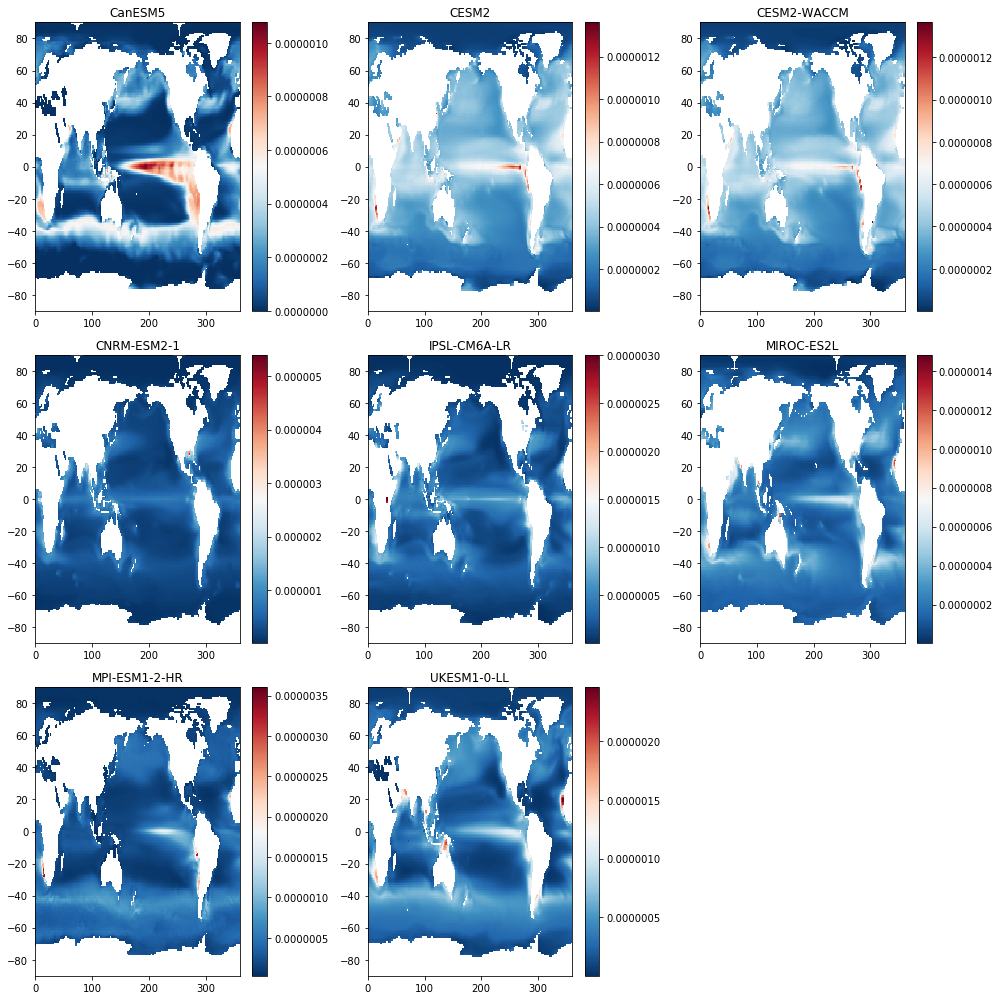

In [72]:
# plotting

plt.figure(figsize=(14,14))
i = 0
for model in new_models:  
    i = i + 1
    if isinstance(xray_dic[model], list):
        continue
    else:
        s = regrid_dic[model].mean(dim='time')
    ax = plt.subplot(3,3,i)
    plt.pcolormesh(regrid_dic[model].lon, regrid_dic[model].lat, s, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    ax.title.set_text(str(model))
plt.tight_layout()
plt.savefig('intpp_start.png', dpi=600)
#plt.savefig('intpp_end.png', dpi=600)
#plt.savefig('intpp_diff.png', dpi=600)

In [14]:
client.close()
cluster.close()

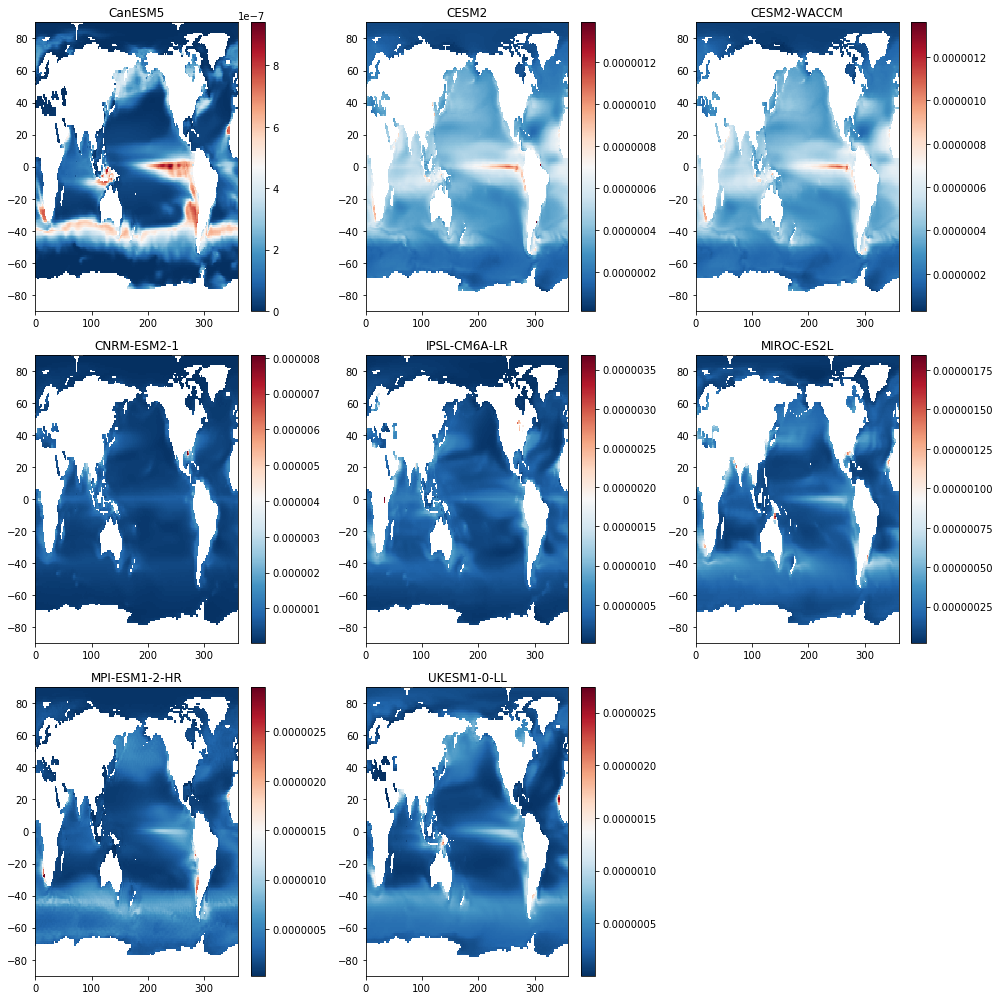

In [73]:
# plotting the end

plt.figure(figsize=(14,14))
i = 0
for model in new_models:  
    i = i + 1
    #if isinstance(xray2_dic[model], list):
    #    continue
    #else:
    s = regrid_dic2[model].mean(dim='time')
    ax = plt.subplot(3,3,i)
    plt.pcolormesh(regrid_dic2[model].lon, regrid_dic2[model].lat, s, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    ax.title.set_text(str(model))
plt.tight_layout()
plt.savefig('intpp_end.png', dpi=600)
#plt.savefig('intpp_end.png', dpi=600)
#plt.savefig('intpp_diff.png', dpi=600)

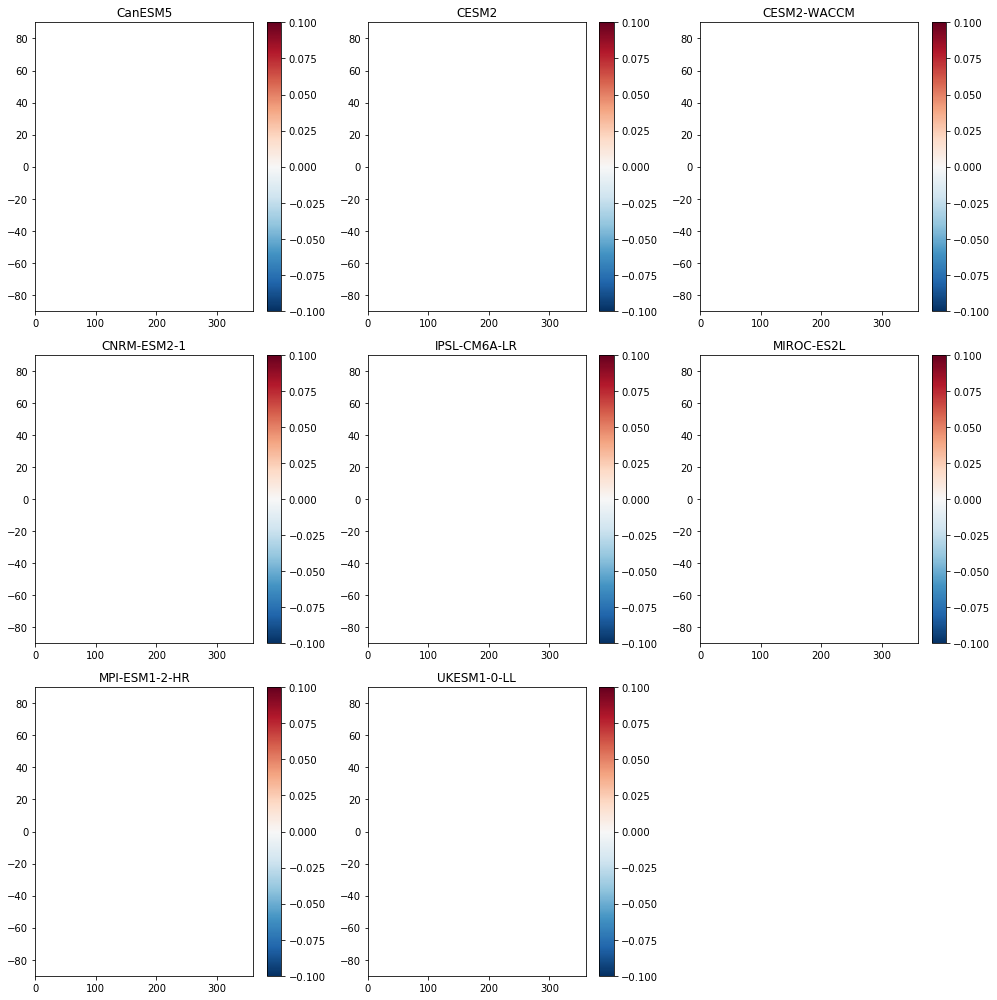

In [74]:
# plotting

plt.figure(figsize=(14,14))
i = 0
for model in new_models:  
    i = i + 1
    #if isinstance(xray_dic[model], list):
    #    continue
    #else:
    s = regrid_dic3[model].mean(dim='time')
    ax = plt.subplot(3,3,i)
    plt.pcolormesh(regrid_dic3[model].lon, regrid_dic3[model].lat, s, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    ax.title.set_text(str(model))
plt.tight_layout()
plt.savefig('intpp_diff.png', dpi=600)
#plt.savefig('intpp_end.png', dpi=600)
#plt.savefig('intpp_diff.png', dpi=600)